## Building Gene Regulatory Networks with BioCRNpyler

In this notebook, we will use RegulatedPromoter and CombinatorialPromoter to model Gene Regulation via Transcription Factors.

_Note: For this notebook to function, you need the default_parameter.txt file in the same folder as the notebook._

### Modeling Gene Regulation by a Single Transcription Factor
In biology, it is very common for a transcription factor to turn on or off promoter. BioCRNpyler has a number of Promoter Components to do this.
* RegulatedPromoter: A list of regulators each bind individually to turn a Promoter ON or OFF (No Combinatorial Logic)
* RepressiblePromoter: A single repressor modelled with a hill function
* ActivatablePromoter: A single activator modeled with a hill function

In the next example, we will produce and compare the outputs of these kinds of promoters.

### Example 1: ActivatablePromoter
A very simple Promoter Component modelled with a hill function. However, this class is not able to accurately capture the binding of Machinery like RNAP and shouldn't be used with Mixtures that include machinery.

In [1]:
from biocrnpyler.core import Species
from biocrnpyler.components import DNAassembly, ActivatablePromoter
from biocrnpyler.mixtures import SimpleTxTlExtract

#ActivatedPromoter Example
activator = Species("activator", material_type = "small_molecule")
S_A = Species("A")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":.01}
#By Loading custom parameters into the promoter, we override the default parameters of the Mixture
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = True, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly(name="activatable_assembly", promoter=P_activatable, rbs="Strong", protein = S_A)

M = SimpleTxTlExtract(name="SimpleTxTl", parameter_file = "default_parameters.txt", components=[activatable_assembly])

CRN = M.compile_crn();

print(CRN.pretty_print(show_rates = True, show_keys = True))

Species(N = 4) = {
small_molecule[activator] (@ 0),  rna[activatable_assembly] (@ 0),  dna[activatable_assembly] (@ 0),  A (@ 0),  
}

Reactions (4) = [
0. dna[activatable_assembly] --> dna[activatable_assembly]+rna[activatable_assembly]
 Kf = k dna[activatable_assembly] small_molecule[activator]^n / ( K^n + small_molecule[activator]^n )
  k=1.0
  found_key=(mech=None, partid=None, name=k).
  search_key=(mech=positivehill_transcription, partid=P_activtable_activator, name=k).
  K=20
  found_key=(mech=None, partid=None, name=K).
  search_key=(mech=positivehill_transcription, partid=P_activtable_activator, name=K).
  n=4
  found_key=(mech=None, partid=None, name=n).
  search_key=(mech=positivehill_transcription, partid=P_activtable_activator, name=n).

1. dna[activatable_assembly] --> dna[activatable_assembly]+rna[activatable_assembly]
 Kf=k_forward * dna_activatable_assembly
  k_forward=0.01
  found_key=(mech=None, partid=None, name=kleak).
  search_key=(mech=positivehill_transcription,

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


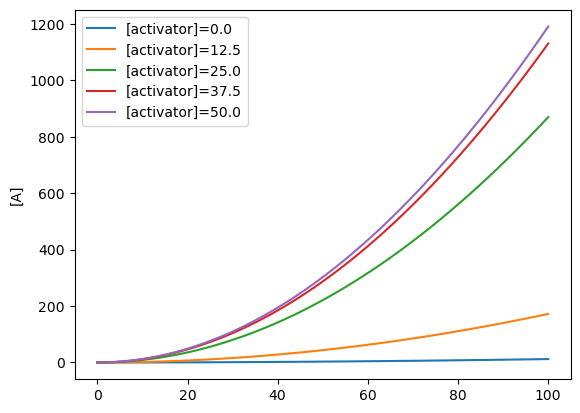

In [2]:
#Titrate the activator and plot the result
try:
    import bioscrape
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    %matplotlib inline
    import numpy as np
    import pandas as pd
    
    for a_c in np.linspace(0, 50, 5):
        x0 = {activatable_assembly.dna:1, activator:a_c}
        timepoints = np.linspace(0, 100, 100)
        R = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
        plt.plot(R["time"], R[str(S_A)], label = "[activator]="+str(a_c))

    plt.ylabel(f"[{S_A}]")
    plt.legend()
    plt.show()

### Example 2: RepressiblePromoter
A very simple Promoter Component modelled with a hill function. However, this class is not able to accurately capture the binding of Machinery like RNAP and shouldn't be used with Mixtures that include machinery.

In [3]:
from biocrnpyler.components import RepressiblePromoter
#ActivatedPromoter Example
repressor = S_A #defined in the previous example
reporter = Species("reporter", material_type = "protein")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":.01}
#By Loading custom parameters into the promoter, we override the default parameters of the Mixture
P_repressible = RepressiblePromoter("P_repressible", repressor = repressor, leak = True, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
repressible_assembly = DNAassembly(name="reporter", promoter=P_repressible, rbs="Strong", protein = reporter)

M = SimpleTxTlExtract(name="SimpleTxTl", parameter_file = "default_parameters.txt", components=[repressible_assembly])

CRN = M.compile_crn()

print(CRN.pretty_print(show_rates = True, show_keys = True))

Species(N = 4) = {
protein[reporter] (@ 0),  rna[reporter] (@ 0),  dna[reporter] (@ 0),  A (@ 0),  
}

Reactions (4) = [
0. dna[reporter] --> dna[reporter]+rna[reporter]
 Kf = k dna[reporter] / ( 1 + (A/K)^4 )
  k=1.0
  found_key=(mech=None, partid=None, name=k).
  search_key=(mech=negativehill_transcription, partid=P_repressible_A, name=k).
  K=20
  found_key=(mech=None, partid=None, name=K).
  search_key=(mech=negativehill_transcription, partid=P_repressible_A, name=K).
  n=4
  found_key=(mech=None, partid=None, name=n).
  search_key=(mech=negativehill_transcription, partid=P_repressible_A, name=n).

1. dna[reporter] --> dna[reporter]+rna[reporter]
 Kf=k_forward * dna_reporter
  k_forward=0.01
  found_key=(mech=None, partid=None, name=kleak).
  search_key=(mech=negativehill_transcription, partid=P_repressible_A, name=kleak).

2. rna[reporter] --> rna[reporter]+protein[reporter]
 Kf=k_forward * rna_reporter
  k_forward=0.25
  found_key=(mech=simple_translation, partid=None, name=ktl).

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


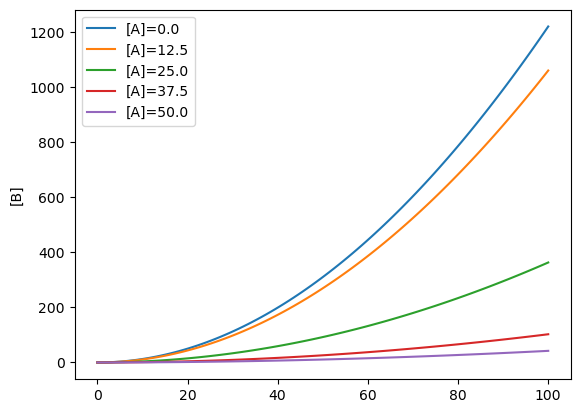

In [4]:
#Titrate the repressor and plot the result
try:
    import bioscrape
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    import numpy as np
    import pylab as plt
    import pandas as pd

    for r_c in np.linspace(0, 50, 5):
        x0 = {repressible_assembly.dna:1, repressor:r_c}
        timepoints = np.linspace(0, 100, 100)
        R = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
        plt.plot(R["time"], R[str(reporter)], label = f"[{str(S_A)}]={r_c}")

    plt.ylabel("[B]")
    plt.legend()
    plt.show()

### Example 3: A Simple Genetic Regulatory Network
In this example, the activatable_assembly will produce a repressor that represses the repressable_assembly. Notice that activatable_assembly already procues the repressor of the RepressablePromoter...so this is easy!

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


Species(N = 7) = {
protein[reporter] (@ 0),  rna[reporter] (@ 0),  dna[reporter] (@ 0),  small_molecule[activator] (@ 0),  rna[activatable_assembly] (@ 0),  dna[activatable_assembly] (@ 0),  A (@ 0),  
}

Reactions (8) = [
0. dna[reporter] --> dna[reporter]+rna[reporter]
 Kf = k dna[reporter] / ( 1 + (A/K)^4 )
  k=1.0
  K=20
  n=4

1. dna[reporter] --> dna[reporter]+rna[reporter]
 Kf=k_forward * dna_reporter
  k_forward=0.01

2. rna[reporter] --> rna[reporter]+protein[reporter]
 Kf=k_forward * rna_reporter
  k_forward=0.25

3. dna[activatable_assembly] --> dna[activatable_assembly]+rna[activatable_assembly]
 Kf = k dna[activatable_assembly] small_molecule[activator]^n / ( K^n + small_molecule[activator]^n )
  k=1.0
  K=20
  n=4

4. dna[activatable_assembly] --> dna[activatable_assembly]+rna[activatable_assembly]
 Kf=k_forward * dna_activatable_assembly
  k_forward=0.01

5. rna[activatable_assembly] --> rna[activatable_assembly]+A
 Kf=k_forward * rna_activatable_assembly
  k_forward=0.2

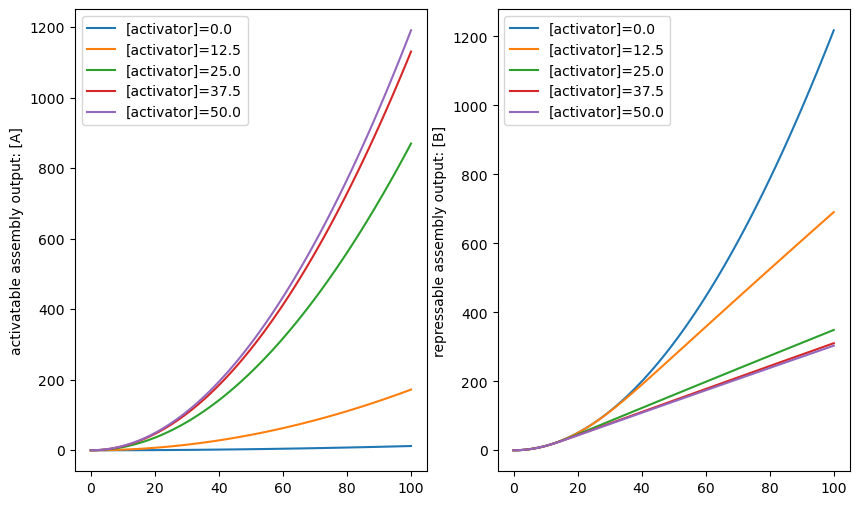

In [5]:
M = SimpleTxTlExtract(name="SimpleTxTl", parameter_file = "default_parameters.txt", components=[repressible_assembly, activatable_assembly])
CRN = M.compile_crn()
print(CRN.pretty_print(show_rates = True, show_keys = False))

#Titrate the activator, which in turn will automatically produce the repressor
try:
    import bioscrape 
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    import numpy as np
    import pylab as plt
    import pandas as pd
    plt.figure(figsize = (10, 6))
    ax1, ax2 = plt.subplot(121), plt.subplot(122)#Create two subplots
    for a_c in np.linspace(0, 50, 5):
        x0 = {activatable_assembly.dna:1, repressible_assembly.dna:1, activator:a_c}
        timepoints = np.linspace(0, 100, 100)
        R = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
        plt.sca(ax1)
        plt.plot(R["time"], R[str(S_A)], label = "[activator]="+str(a_c))
        plt.sca(ax2)
        plt.plot(R["time"], R[str(reporter)], label = "[activator]="+str(a_c))

    plt.sca(ax1)
    plt.ylabel("activatable assembly output: [A]")
    plt.legend()
    plt.sca(ax2)
    plt.ylabel("repressable assembly output: [B]")
    plt.legend()
    plt.show()

### Example 4: RegulatedPromoter
In the below example, a CRN from RegulatedPromoter is generated. This Component models the detailed binding of regulators to the DNA and has seperate transcription rates for each regulator. It is suitable for complex models that include machinery. Regulators do not act Combinatorically.

In [6]:
from biocrnpyler.core import ParameterKey
from biocrnpyler.components import RegulatedPromoter
from biocrnpyler.mixtures import TxTlExtract
#1 Regulated Promoter Needs lots of parameters!
component_parameters = {
    #Promoter Activator Binding Parameters. Note the part_id = [promoter_name]_[regulator_name]
    ParameterKey(mechanism = 'binding', part_id = 'regulated_promoter_A', name = 'kb'):100, #Promoter - Activator Binding
    ParameterKey(mechanism = 'binding', part_id = "regulated_promoter_A", name = 'ku'):5.0, #Unbinding
    ParameterKey(mechanism = 'binding', part_id = "regulated_promoter_A", name = 'cooperativity'):4.0, #Cooperativity
    
    #Activated Promoter Transcription. Note the part_id = [promoter_name]_[regulator_name]
    #These regulate RNAP binding to an activated promoter and transcription
    ParameterKey(mechanism = 'transcription', part_id = 'regulated_promoter_A', name = 'kb'):100, #Promoter - Activator Binding
    ParameterKey(mechanism = 'transcription', part_id = "regulated_promoter_A", name = 'ku'):1.0, #Unbinding
    ParameterKey(mechanism = 'transcription', part_id = 'regulated_promoter_A', name = "ktx"): 1., #Transcription Rate
    
    #Promoter Repressor Binding Parameters. Note the part_id = [promoter_name]_[regulator_name]
    ParameterKey(mechanism = 'binding', part_id = 'regulated_promoter_R', name = 'kb'):100,
    ParameterKey(mechanism = 'binding', part_id = "regulated_promoter_R", name = 'ku'):5.0,
    ParameterKey(mechanism = 'binding', part_id = "regulated_promoter_R", name = 'cooperativity'):4.0,
    
    #Repressed Promoter Transcription. Note the part_id = [promoter_name]_[regulator_name]
    #These regulate RNAP binding to a repressed promoter and transcription
    ParameterKey(mechanism = 'transcription', part_id = 'regulated_promoter_R', name = 'kb'):1,
    ParameterKey(mechanism = 'transcription', part_id = "regulated_promoter_R", name = 'ku'):100.0,
    ParameterKey(mechanism = 'transcription', part_id = 'regulated_promoter_R', name = "ktx"): 1.0, #Transcription Rate
    
    #Leak Parameters for transcription
    #These regulate expression of an unbound promoter
    ParameterKey(mechanism = 'transcription', part_id = 'regulated_promoter_leak', name = "kb"): 2.,
    ParameterKey(mechanism = 'transcription', part_id = 'regulated_promoter_leak', name = "ku"): 100,
    ParameterKey(mechanism = 'transcription', part_id = 'regulated_promoter_leak', name = "ktx"): 1.0, #Transcription Rate
}

repressor = Species("R", material_type = "protein")
activator = Species("A", material_type = "protein")
reporter = Species("reporter", material_type = "protein")

#Create a RegulatedPromoter Object named "P_reg" with regulators "activator" and "repressor"
#By Loading custom parameters into the promoter, we override the default parameters of the Mixture
P_reg = RegulatedPromoter("regulated_promoter", regulators=[activator, repressor], leak=True, parameters = component_parameters)

#Create a DNA assembly "reporter" with P_reg for its promoter
reg_reporter = DNAassembly(name="reporter", promoter=P_reg, rbs="Strong", protein = reporter)

#Use a simple TxTl model with dilution
#M = SimpleTxTlDilutionMixture(name="e coli", parameter_file = "default_parameters.txt", components=[reg_reporter])
M = TxTlExtract(name="e coli extract", parameter_file = "default_parameters.txt", components=[reg_reporter])

CRN = M.compile_crn()
print(CRN.pretty_print(show_rates = True, show_keys = False))

Species(N = 16) = {
protein[Ribo] (@ 24.0),  protein[RNAase] (@ 6.0),  protein[RNAP] (@ 3.0),  protein[reporter] (@ 0),  rna[reporter] (@ 0),  dna[reporter] (@ 0),  complex[protein[Ribo]:rna[reporter]] (@ 0),  complex[protein[RNAase]:rna[reporter]] (@ 0),  complex[dna[reporter]:2x_protein[R]] (@ 0),  complex[dna[reporter]:protein[RNAP]] (@ 0),  complex[dna[reporter]:2x_protein[A]] (@ 0),  complex[complex[protein[Ribo]:rna[reporter]]:protein[RNAase]] (@ 0),  complex[complex[dna[reporter]:2x_protein[R]]:protein[RNAP]] (@ 0),  complex[complex[dna[reporter]:2x_protein[A]]:protein[RNAP]] (@ 0),  protein[R] (@ 0),  protein[A] (@ 0),  
}

Reactions (14) = [
0. dna[reporter]+protein[RNAP] <--> complex[dna[reporter]:protein[RNAP]]
 Kf=k_forward * dna_reporter * protein_RNAP
 Kr=k_reverse * complex_dna_reporter_protein_RNAP_
  k_forward=2.0
  k_reverse=100

1. complex[dna[reporter]:protein[RNAP]] --> dna[reporter]+rna[reporter]+protein[RNAP]
 Kf=k_forward * complex_dna_reporter_protein_RNAP_
  k

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


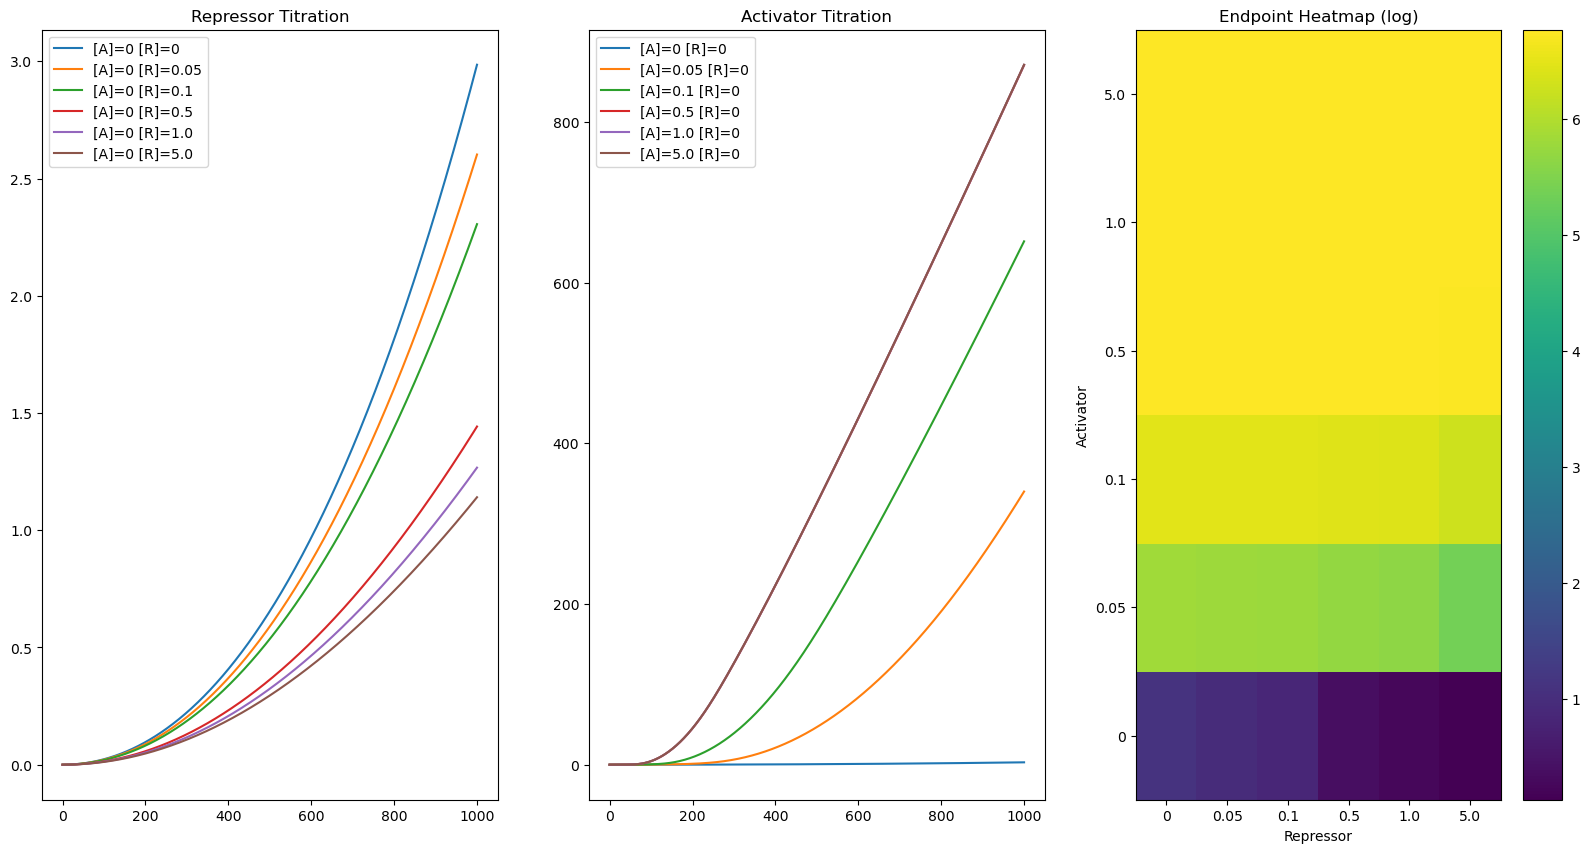

In [7]:
#Lets titrate Repressor and Activator - notice the bahvior is not combinatorial
try:
    import bioscrape 
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    import numpy as np
    import pylab as plt
    import pandas as pd
    plt.figure(figsize = (20, 10))
    ax1, ax2, ax3 = plt.subplot(131), plt.subplot(132), plt.subplot(133)
    titration_list = [0, .05, .1, .5, 1.0, 5.]
    N = len(titration_list)
    HM = np.zeros((N, N))
    for a_ind, a_c in enumerate(titration_list):
        for r_ind, r_c in enumerate(titration_list):
            x0 = {reg_reporter.dna:.1, repressor:r_c, activator:a_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
            if a_ind == 0:
                plt.sca(ax1)
                plt.plot(R["time"], R[str(reporter)], label = "[A]="+str(a_c) +" [R]="+str(r_c))
            if r_ind == 0:
                plt.sca(ax2)
                plt.plot(R["time"], R[str(reporter)], label = "[A]="+str(a_c) +" [R]="+str(r_c))
            HM[a_ind, r_ind] = R[str(reporter)][len(timepoints)-1]

    plt.sca(ax1)
    plt.title("Repressor Titration")
    plt.legend()
    plt.sca(ax2)
    plt.title("Activator Titration")
    plt.legend()
    plt.sca(ax3)
    plt.title("Endpoint Heatmap (log)")
    cb = plt.pcolor(np.log(HM))
    plt.colorbar(cb)
    plt.xlabel("Repressor")
    plt.ylabel("Activator")
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in titration_list])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in titration_list])
    plt.show()

### Example 5: Induction Model of a Ligand which Activates a Transcription Factor
In many biological circuits, small molecules (ligands) can bind to a transcription factor modulating its functionality. 

In BioCRNpyler, we will model this by creating a ChemicalComplex Component which consists of a Transcription Factor and a ligand. This the ComplexSpecies formed by by binding the transcription  will also work as the regulator (activator or repressor) of a regulated promoter. In this example, we will use RepressablePromoter. 

In the activating case, the bound form of the ChemicalComplex will induce gene expression.

In [8]:
from biocrnpyler.components import ChemicalComplex
from biocrnpyler.mixtures import ExpressionDilutionMixture

inactive_repressor = Species("A", material_type = "protein")
ligand = Species("L", material_type = "ligand")

#Create a ChemicalComplex to model ligand-inactive_repressor bindning
activatable_repressor = ChemicalComplex([inactive_repressor, ligand])

#Other Promoters could also be used
P_repressible = RepressiblePromoter("P_repressible", repressor = activatable_repressor.get_species(), leak = True, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
repressible_assembly = DNAassembly(name="reporter", promoter=P_repressible, rbs="Strong", protein = "reporter")

M = ExpressionDilutionMixture(name="ExpressionDilutionMixture", parameter_file = "default_parameters.txt", components=[repressible_assembly, activatable_repressor])
CRN = M.compile_crn();print(CRN.pretty_print(show_rates = True, show_keys = False))

Species(N = 5) = {
protein[reporter] (@ 0),  dna[reporter] (@ 0),  complex[ligand[L]:protein[A]] (@ 0),  ligand[L] (@ 0),  protein[A] (@ 0),  
}

Reactions (7) = [
0. dna[reporter] --> dna[reporter]+protein[reporter]
 Kf = k dna[reporter] / ( 1 + (complex[ligand[L]:protein[A]]/K)^4 )
  k=1.0
  K=20
  n=4

1. dna[reporter] --> dna[reporter]+protein[reporter]
 Kf=k_forward * dna_reporter
  k_forward=0.01

2. ligand[L]+protein[A] <--> complex[ligand[L]:protein[A]]
 Kf=k_forward * ligand_L * protein_A
 Kr=k_reverse * complex_ligand_L_protein_A_
  k_forward=100.0
  k_reverse=10.0

3. complex[ligand[L]:protein[A]] --> 
 Kf=k_forward * complex_ligand_L_protein_A_
  k_forward=0.001

4. protein[reporter] --> 
 Kf=k_forward * protein_reporter
  k_forward=0.001

5. ligand[L] --> 
 Kf=k_forward * ligand_L
  k_forward=0.001

6. protein[A] --> 
 Kf=k_forward * protein_A
  k_forward=0.001

]


C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


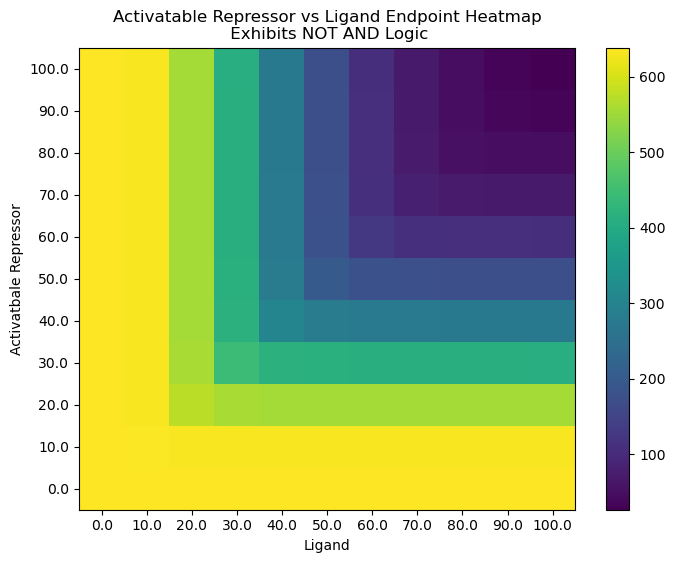

In [9]:
#Lets titrate ligand and repressor
try:
    import bioscrape 
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    import numpy as np
    import pylab as plt
    import pandas as pd
    plt.figure(figsize = (8, 6))
    N = 11 #Number of titrations
    max_titration = 100
    HM = np.zeros((N, N))
    for r_ind, R_c in enumerate(np.linspace(0, max_titration, N)):
        for l_ind, L_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {repressible_assembly.dna:1, inactive_repressor:R_c, ligand:L_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
            HM[r_ind, l_ind] = R["protein_reporter"][len(timepoints)-1]

    plt.title("Activatable Repressor vs Ligand Endpoint Heatmap\n Exhibits NOT AND Logic")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("Ligand")
    plt.ylabel("Activatbale Repressor")
    
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.show()
    

### Example 6: Induction Models of a Ligand which Deactivates a Transcription Factor
In the inactivating case, the unbound transcription factor will activate the gene and the bound form will not.

In [10]:
repressor = Species("A", material_type = "protein")
ligand = Species("L", material_type = "ligand")

#Create a ChemicalComplex to model ligand-inactive_repressor bindning
inactive_repressor = ChemicalComplex([repressor, ligand])

#Other Promoters could also be Used
P_repressible = RepressiblePromoter("P_repressible", repressor = repressor, leak = True, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
repressible_assembly = DNAassembly(name="reporter", promoter=P_repressible, rbs="Strong", protein = "reporter")

M = ExpressionDilutionMixture(name="ExpressionDilutionMixture", parameter_file = "default_parameters.txt", components=[repressible_assembly, activatable_repressor])
CRN = M.compile_crn();print(CRN.pretty_print(show_rates = True, show_keys = False))

Species(N = 5) = {
protein[reporter] (@ 0),  dna[reporter] (@ 0),  complex[ligand[L]:protein[A]] (@ 0),  ligand[L] (@ 0),  protein[A] (@ 0),  
}

Reactions (7) = [
0. dna[reporter] --> dna[reporter]+protein[reporter]
 Kf = k dna[reporter] / ( 1 + (protein[A]/K)^4 )
  k=1.0
  K=20
  n=4

1. dna[reporter] --> dna[reporter]+protein[reporter]
 Kf=k_forward * dna_reporter
  k_forward=0.01

2. ligand[L]+protein[A] <--> complex[ligand[L]:protein[A]]
 Kf=k_forward * ligand_L * protein_A
 Kr=k_reverse * complex_ligand_L_protein_A_
  k_forward=100.0
  k_reverse=10.0

3. protein[A] --> 
 Kf=k_forward * protein_A
  k_forward=0.001

4. protein[reporter] --> 
 Kf=k_forward * protein_reporter
  k_forward=0.001

5. ligand[L] --> 
 Kf=k_forward * ligand_L
  k_forward=0.001

6. complex[ligand[L]:protein[A]] --> 
 Kf=k_forward * complex_ligand_L_protein_A_
  k_forward=0.001

]


C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


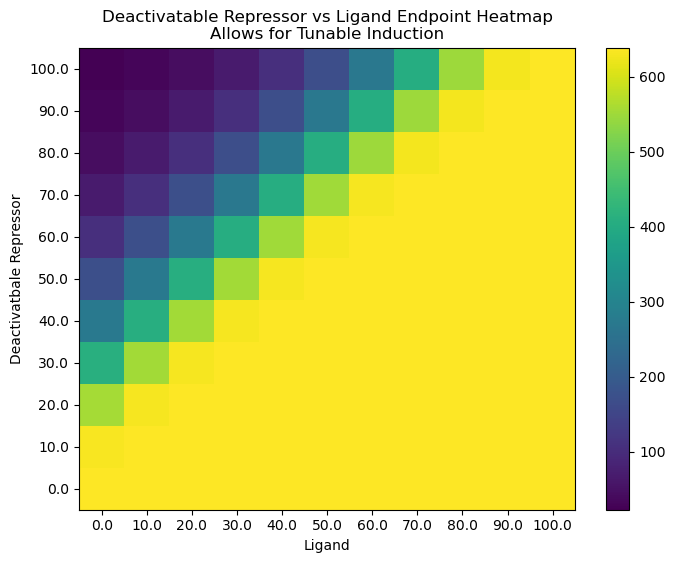

In [11]:
#Titration of ligand and repressor
try:
    import bioscrape 
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    import numpy as np
    import pylab as plt
    import pandas as pd
    
    plt.figure(figsize = (8, 6))
    N = 11 #Number of titrations
    max_titration = 100
    HM = np.zeros((N, N))
    for r_ind, R_c in enumerate(np.linspace(0, max_titration, N)):
        for l_ind, L_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {repressible_assembly.dna:1, repressor:R_c, ligand:L_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
            HM[r_ind, l_ind] = R["protein_reporter"][len(timepoints)-1]

    plt.title("Deactivatable Repressor vs Ligand Endpoint Heatmap\nAllows for Tunable Induction")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("Ligand")
    plt.ylabel("Deactivatbale Repressor")
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.show() 

### Example 7: Modeling AND, OR, and XOR Promoters with Combinatorial Promoter
CombinatorialPromoter is a Component designed to model arbitrary combinatorial logic on a promoter. For example, a promoter with 2 transcription factor binding sites can have 4 differents states:
* Nothing bound
* just factor 1 bound
* just factor 2 bound
* factors 1 and 2 bound

In general, a promoter with $N$ binding sites has up to $2^N$ possible states. Combinatorial promoter enumerates all these states and allows for the modeller to decide which are capable of transcription and which are not. For more details on this class, see the CombinatorialPromoter example ipython notebook in the BioCRNpyler examples folder.

Below, we will use a Combinatorial Promoter to Produce OR, AND, and XOR logic with two species, $A$ and $B$ by passing in lists of the transcribable combinations of regulators to the tx_capable_list keyword.


C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


Species(N = 7) = {
protein[GFP] (@ 0),  complex[2x_B:dna[AND]] (@ 0),  B (@ 0),  complex[2x_A:dna[AND]] (@ 0),  complex[2x_A:2x_B:dna[AND]] (@ 0),  dna[AND] (@ 0),  A (@ 0),  
}

Reactions (8) = [
0. dna[AND] --> dna[AND]+protein[GFP]
 Kf=k_forward * dna_AND
  k_forward=0.0028125

1. 2A+dna[AND] <--> complex[2x_A:dna[AND]]
 Kf=k_forward * A^2 * dna_AND
 Kr=k_reverse * complex_A_2x_dna_AND_
  k_forward=100.0
  k_reverse=10.0

2. 2B+dna[AND] <--> complex[2x_B:dna[AND]]
 Kf=k_forward * B^2 * dna_AND
 Kr=k_reverse * complex_B_2x_dna_AND_
  k_forward=100.0
  k_reverse=10.0

3. 2A+complex[2x_B:dna[AND]] <--> complex[2x_A:2x_B:dna[AND]]
 Kf=k_forward * A^2 * complex_B_2x_dna_AND_
 Kr=k_reverse * complex_A_2x_B_2x_dna_AND_
  k_forward=100.0
  k_reverse=10.0

4. 2B+complex[2x_A:dna[AND]] <--> complex[2x_A:2x_B:dna[AND]]
 Kf=k_forward * B^2 * complex_A_2x_dna_AND_
 Kr=k_reverse * complex_A_2x_B_2x_dna_AND_
  k_forward=100.0
  k_reverse=10.0

5. complex[2x_A:2x_B:dna[AND]] --> complex[2x_A:2x_B:d

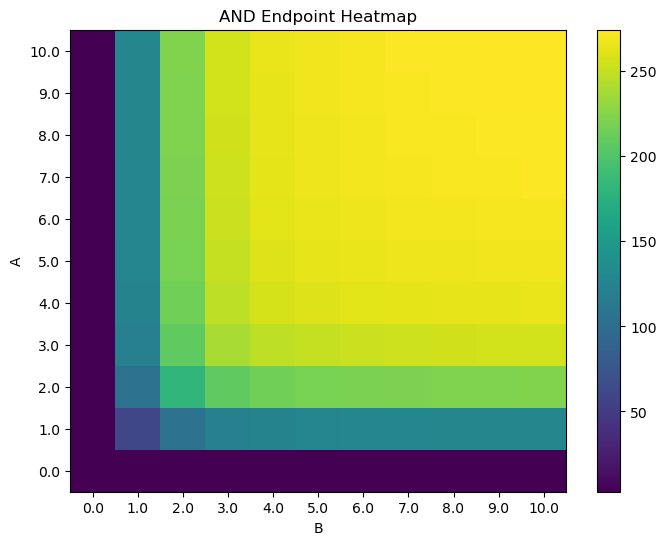

In [12]:
from biocrnpyler.components import CombinatorialPromoter
from biocrnpyler.mixtures import ExpressionExtract

#AND Logic
A = Species("A") ;B = Species("B") #Inducers

#Create the Combinatorial Promoter
Prom_AND = CombinatorialPromoter("combinatorial_promoter",[A,B], tx_capable_list = [[A,B]], leak = True) #the Combination A and B can be transcribed
AND_assembly = DNAassembly("AND",promoter=Prom_AND,rbs="medium",protein="GFP")
#Use an Expression Mixture to focus on Logic, not Transcription & Translation

M = ExpressionExtract(name="expression", parameter_file = "default_parameters.txt", components=[AND_assembly])
CRN = M.compile_crn(); print(CRN.pretty_print(show_rates = True, show_keys = False))

#Lets titrate A and B
try:
    import bioscrape
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    import numpy as np
    import pylab as plt
    import pandas as pd
    
    plt.figure(figsize = (8, 6))
    N = 11 #Number of titrations
    max_titration = 10
    HM = np.zeros((N, N))
    for a_ind, A_c in enumerate(np.linspace(0, max_titration, N)):
        for b_ind, B_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {AND_assembly.dna:1, A:A_c, B:B_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
            HM[a_ind, b_ind] = R["protein_GFP"][len(timepoints)-1]

    plt.title("AND Endpoint Heatmap")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("B")
    plt.ylabel("A")
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.show()

DNAassembly: OR
Species(N = 7) = {
dna[OR] (@ 0),  protein[GFP] (@ 0),  complex[2x_B:dna[OR]] (@ 0),  B (@ 0),  complex[2x_A:dna[OR]] (@ 0),  complex[2x_A:2x_B:dna[OR]] (@ 0),  A (@ 0),  
}

Reactions (7) = [
0. 2A+dna[OR] <--> complex[2x_A:dna[OR]]
 Kf=k_forward * A^2 * dna_OR
 Kr=k_reverse * complex_A_2x_dna_OR_
  k_forward=100.0
  k_reverse=10.0

1. 2B+dna[OR] <--> complex[2x_B:dna[OR]]
 Kf=k_forward * B^2 * dna_OR
 Kr=k_reverse * complex_B_2x_dna_OR_
  k_forward=100.0
  k_reverse=10.0

2. 2A+complex[2x_B:dna[OR]] <--> complex[2x_A:2x_B:dna[OR]]
 Kf=k_forward * A^2 * complex_B_2x_dna_OR_
 Kr=k_reverse * complex_A_2x_B_2x_dna_OR_
  k_forward=100.0
  k_reverse=10.0

3. 2B+complex[2x_A:dna[OR]] <--> complex[2x_A:2x_B:dna[OR]]
 Kf=k_forward * B^2 * complex_A_2x_dna_OR_
 Kr=k_reverse * complex_A_2x_B_2x_dna_OR_
  k_forward=100.0
  k_reverse=10.0

4. complex[2x_A:dna[OR]] --> complex[2x_A:dna[OR]]+protein[GFP]
 Kf=k_forward * complex_A_2x_dna_OR_
  k_forward=0.28125

5. complex[2x_B:dna[O

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


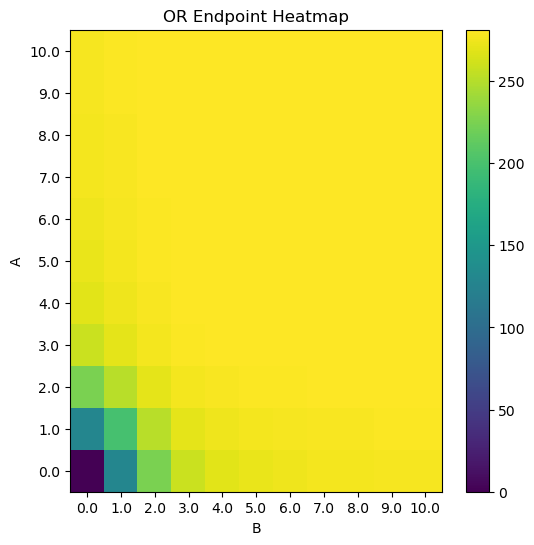

In [13]:
#Create OR Logic
Prom_OR = CombinatorialPromoter("combinatorial_promoter",[A,B], leak=False,
                              tx_capable_list = [[A,B], [A], [B]]) #the Combinations A and B or just A or just B be transcribed

ORassembly = DNAassembly("OR",promoter=Prom_OR,rbs="medium",protein="GFP")
print(ORassembly)
#Use an Expression Mixture to focus on Logic, not Transcription & Translation
M = ExpressionExtract(name="expression", parameter_file = "default_parameters.txt", components=[ORassembly])
CRN = M.compile_crn()
print(CRN.pretty_print(show_rates = True, show_keys = False))

#Lets titrate A and B
try:
    import bioscrape 
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    import numpy as np
    import pylab as plt
    import pandas as pd
    plt.figure(figsize = (6, 6))
    N = 11 #Number of titrations
    max_titration = 10
    HM = np.zeros((N, N))
    for a_ind, A_c in enumerate(np.linspace(0, max_titration, N)):
        for b_ind, B_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {ORassembly.dna:1, A:A_c, B:B_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
            HM[a_ind, b_ind] = R["protein_GFP"][len(timepoints)-1]
    plt.title("OR Endpoint Heatmap")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("B")
    plt.ylabel("A")
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.show()

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


Species(N = 7) = {
dna[XOR] (@ 0),  protein[GFP] (@ 0),  complex[2x_B:dna[XOR]] (@ 0),  B (@ 0),  complex[2x_A:dna[XOR]] (@ 0),  complex[2x_A:2x_B:dna[XOR]] (@ 0),  A (@ 0),  
}

Reactions (6) = [
0. 2A+dna[XOR] <--> complex[2x_A:dna[XOR]]
 Kf=k_forward * A^2 * dna_XOR
 Kr=k_reverse * complex_A_2x_dna_XOR_
  k_forward=100.0
  k_reverse=10.0

1. 2B+dna[XOR] <--> complex[2x_B:dna[XOR]]
 Kf=k_forward * B^2 * dna_XOR
 Kr=k_reverse * complex_B_2x_dna_XOR_
  k_forward=100.0
  k_reverse=10.0

2. 2A+complex[2x_B:dna[XOR]] <--> complex[2x_A:2x_B:dna[XOR]]
 Kf=k_forward * A^2 * complex_B_2x_dna_XOR_
 Kr=k_reverse * complex_A_2x_B_2x_dna_XOR_
  k_forward=100.0
  k_reverse=10.0

3. 2B+complex[2x_A:dna[XOR]] <--> complex[2x_A:2x_B:dna[XOR]]
 Kf=k_forward * B^2 * complex_A_2x_dna_XOR_
 Kr=k_reverse * complex_A_2x_B_2x_dna_XOR_
  k_forward=100.0
  k_reverse=10.0

4. complex[2x_A:dna[XOR]] --> complex[2x_A:dna[XOR]]+protein[GFP]
 Kf=k_forward * complex_A_2x_dna_XOR_
  k_forward=0.28125

5. complex[2x_

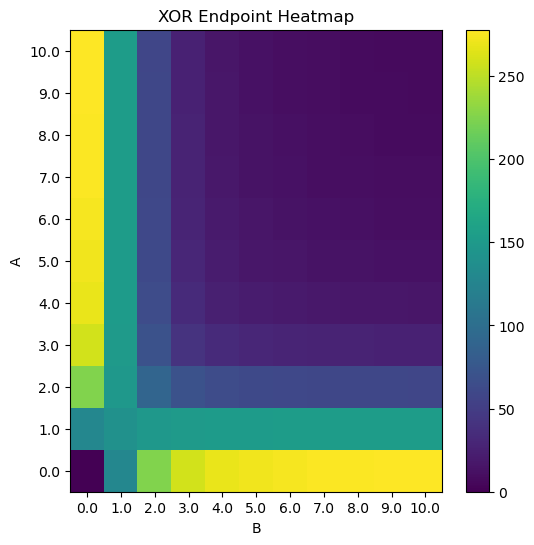

In [14]:
#Create XOR Logic
Prom_XOR = CombinatorialPromoter("combinatorial_promoter",[A,B], leak=False,
                              tx_capable_list = [[A], [B]]) #the Combinations just A or just B can be transcribed

XORassembly = DNAassembly("XOR",promoter=Prom_XOR,rbs="medium",protein="GFP")

#Use an Expression Mixture to focus on Logic, not Transcription & Translation
M = ExpressionExtract(name="expression", parameter_file = "default_parameters.txt", components=[XORassembly])
CRN = M.compile_crn()
print(CRN.pretty_print(show_rates = True, show_keys = False))

#Lets titrate A and B
try:
    import bioscrape 
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    import numpy as np
    import pylab as plt
    import pandas as pd
  
    plt.figure(figsize = (6, 6))
    N = 11 #Number of titrations
    max_titration = 10
    HM = np.zeros((N, N))
    for a_ind, A_c in enumerate(np.linspace(0, max_titration, N)):
        for b_ind, B_c in enumerate(np.linspace(0, max_titration, N)):
            x0 = {XORassembly.dna:1, A:A_c, B:B_c}
            timepoints = np.linspace(0, 1000, 1000)
            R = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
            HM[a_ind, b_ind] = R["protein_GFP"][len(timepoints)-1]
    plt.title("XOR Endpoint Heatmap")
    cb = plt.pcolor(HM)
    plt.colorbar(cb)
    plt.xlabel("B")
    plt.ylabel("A")
    
    plt.xticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.yticks(np.arange(.5, N+.5, 1), [str(i) for i in np.linspace(0, max_titration, N)])
    plt.show()

In [15]:
# End